# 1. CNN for image classification on CIFAR-10
-  The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. 
-  There are 50000 training images and 10000 test images.

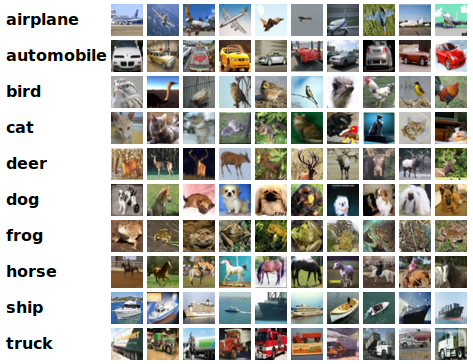

In [1]:
# # adjust cell width
# from IPython.core.display import display, HTML 
# display(HTML("<style>.container { width:100% !important; }</style>")) 

In [2]:
# lib
import tensorflow as tf
# enable eager execution
tf.enable_eager_execution()

import tensorflow.keras as K

In [3]:
# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


In [4]:
cifar10 = K.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


In [5]:
train_images = train_images[0:500]
train_labels = train_labels[0:500]

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
num_classes = len(class_names)

print(num_classes)

10


In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# 2. CNN model

## 2.1 build model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense


In [10]:
bn_axis = 3

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=train_images.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)    

In [11]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 3. Multiple-weights Self-paced CNN

## 3.1 Training loop

### the loss function of CNN 
$$  E_{CN} (w) = \sum_{i=1}^{n}L(y_{i},g(x_{i},w))   = -\frac{1}{n}\sum_{i=1}^{n}log p_{model}[y_i \in C_{y_{i}} ]      $$  $$

In [12]:
# define loss function based on equation (14)
def loss(model, x, y):
    _y = model(x)
    return K.losses.sparse_categorical_crossentropy(y, _y)


### the objective function value

$$  E_{SPCN} (w) = \sum_{i=1}^{n}v_{i}L(y_{i},g(x_{i},w))         $$
$$ \Delta w = -\eta \frac{\partial E_{SPCN}^{i}}{\partial w} = -v_{i} * \eta \frac{\partial E_{CN}^{i}}{\partial w}$$ 

In [13]:
# calculate loss value and gradient
def grad(model, inputs, labels, v):
    with tf.GradientTape() as tape:
        loss_value = v*loss(model, inputs, labels)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [14]:
# initialize
optimizer = tf.train.AdadeltaOptimizer()
global_step = tf.Variable(0)

num_epochs = 10

# tf require float32 data type
train_x = np.float32(train_images)
test_x = np.float32(test_images)

# Initialization: θ, v, λ, μ
# model weights θ is initialized automatically
# sampe weights v is randomly uniform [0.1,1)
train_v = np.random.uniform(0.01,1.0, train_x.shape[0])
# initialize v all 0.1
#train_v = np.full((len(train_x),),0.1)
train_v = np.float32(train_v)
# the age parameter λ that controls the learning pace
# When λ is small, the model is young, and only easy samples with small losses are considered.
# sparse regularizer f(v;λ) = (λ/(2×3))v^3−λv
age = 1 # paper did not give a value
# the age parameter λ=μλ at each step
# μ is set to be 1.3 experimentally
mu = 1.3

# initilize gamma
gamma = 0.5


### Linear Soft Weighting

$$       f(v,\lambda ) = \lambda (\frac{1}{2} || v ||^2 - \sum_{i=1}^{n}v_i)\rightarrow v_{i}^{*}(\lambda , l) = \begin{Bmatrix}
-\frac{1}{\lambda} + 1, & 1<\lambda  \\ 
0, & 1\geq \lambda  
\end{Bmatrix}            $$

In [15]:
def linearSoftWeight(l,age,v):
    if l < age:
        new_v = 1-1/age
    else:
        new_v = 0  
    return new_v
    

### Logarithmic Soft Weighting

$$  f(v,\lambda ) = \sum_{i=1}^{n}(1 - \lambda )v_i - \frac{(1 - \lambda )^{v_i}}{log(1 - \lambda )} \rightarrow v_{i}^{*} (\lambda, l) = \begin{Bmatrix}
\frac{log(l + 1 - \lambda )}{log(1 - \lambda )}, & 1 < \lambda \\ 
0, & 1\geqslant \lambda 
\end{Bmatrix}    $$

In [16]:
def logSoftWeight(l,age,v):
    if l < age:
        new_v = np.log(l+1-age)/np.log(1-age)
    else:
        new_v = 0
    return new_v


### Mixture Weighting

$$     f(v,\lambda ,\gamma ) = \sum_{i=1}^{n}\frac{\gamma^2 }{v_i + \gamma /\lambda }\rightarrow v_{i}^{*} (\lambda , \gamma ,l) = \begin{Bmatrix}
1, & l < (\frac{\lambda \gamma }{\lambda + \gamma })^2 \\ 
0, & 1 \geq \lambda ^2\\ 
\gamma (\frac{1}{\sqrt{l}} - \frac{1}{\lambda }), & otherwise
\end{Bmatrix}        $$

In [17]:
def mixtureWeight(l,age,v,gamma):
    if l < (age*gamma/(age+gamma))**2:
        new_v = 1.0
    elif l >= age**2:
        new_v = 0.0
    else:
        new_v = gamma*((1.0/np.sqrt(l))-(1.0/age))
    return new_v
    

In [18]:
def simpleWeight(l,age,v):
    if l < age/2.0:
        new_v = 1
    elif age/2.0 <= l <= age:
        new_v = np.sqrt(2 - 2*l/age)
    else:
        new_v = 0.0
    return new_v

In [19]:
%%time

train_accu = []
test_accu = []
v_hist = []
# start training

for epoch in range(num_epochs):

    # Training loop - without batch
    # Optimize the model
    # θ-step : Solving θ by fixed v
    print("\nEpoch: {} ----------------------------------------------".format(epoch+1))
    print("\nage = {}".format(age))
    print("Step 1: fix v, update model weights:")
    progressBar = K.utils.Progbar(target=len(train_x))
    for i in range(len(train_x)):
        x = np.expand_dims(train_x[i], axis=0)
        y = train_labels[i][0]
        v = train_v[i]
        
######### calculate the loss and the gradient of the model         
        
        loss_value, grads = grad(model, x, y, v)
        optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)
        # progressBar.add(1)
        progressBar.update(current=i+1)
    
    # v-step: Solving v by fixed θ using equation (13)
    # update loss value with updated model weights
    print("\nStep 2: fix model weights update v:")
    progressBar = K.utils.Progbar(target=len(train_x))
    for i in range(len(train_x)):
        x = np.expand_dims(train_x[i], axis=0)
        y = train_labels[i][0]
        v = train_v[i]
        _y = model(x) # calculate model output
        l = K.losses.sparse_categorical_crossentropy(y, _y)
        
######### different regularizers for v_step ################


        # print("\nloss_value: {}".format(loss_value))
#         train_v[i] = linearSoftWeight(l,age,v)
#         train_v[i] = logSoftWeight(l,age,v)
        train_v[i] = mixtureWeight(l,age,v,gamma)
#         train_v[i] = simpleWeight(l,age,v)
        
    
        # progressBar.add(1)
        progressBar.update(current=i+1)
        
    # end epoch
    print("Ending epoch")
    _train_y = model.predict(train_x)
    _train_accu = np.mean(K.metrics.sparse_categorical_accuracy(train_labels, _train_y))
    train_accu.append(_train_accu)
    print("\ntrain_accuracy = {}".format(_train_accu))
    # test accuracy on test set
    _test_y = model.predict(test_x)
    _test_accu = np.mean(K.metrics.sparse_categorical_accuracy(test_labels, _test_y))
    test_accu.append(_test_accu)
    print("\ntest_accuracy = {}".format(_test_accu))
    # recording v
    v_hist.append(train_v)
    print("\ntrainig v describe")
    print(pd.Series(train_v).describe())
    print("\n")
    # update age parameter
    age = mu*age




Epoch: 1 ----------------------------------------------

age = 1
Step 1: fix v, update model weights:
500/500 [==============================] - 5s 10ms/step

Step 2: fix model weights update v:
500/500 [==============================] - 2s 3ms/step
Ending epoch

train_accuracy = 0.12200000137090683

test_accuracy = 0.1200999990105629

trainig v describe
count    500.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64



Epoch: 2 ----------------------------------------------

age = 1.3
Step 1: fix v, update model weights:
500/500 [==============================] - 5s 10ms/step

Step 2: fix model weights update v:
500/500 [==============================] - 2s 3ms/step
Ending epoch

train_accuracy = 0.12200000137090683

test_accuracy = 0.1200999990105629

trainig v describe
count    500.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64



Epoch: 

In [20]:
print("\ntrain_accuracy = {}".format(_train_accu))


train_accuracy = 0.12399999797344208
